In [ ]:
# ==============================================================================
# SCRIPT ANALISIS SPASIAL DAN KLASIFIKASI SPI-12 (12-BULANAN)
# STUDI KASUS: PROVINSI JAMBI
# Penulis: Jariyan Arifudin
# Data: CHIRPS v3 (Downscaled & Bias Corrected)
# ==============================================================================

## 1. IMPOR PUSTAKA & INSTALASI
import os

# Cek apakah rioxarray sudah ada, jika belum install
try:
    import rioxarray
except ImportError:
    print("Pustaka rioxarray tidak ditemukan. Menginstal...")
    !pip install rioxarray geopandas rasterio numpy scipy leafmap xarray matplotlib
    print("Instalasi selesai. Silakan Restart Runtime jika masih error.")
    import rioxarray

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio
from rasterio import features
from rasterio.mask import geometry_mask
from shapely.geometry import shape
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import drive

# Instalasi paket tambahan (jika belum ada)
try:
    import leafmap
except ImportError:
    print("Menginstal pustaka geospasial...")
    !pip install rioxarray geopandas rasterio numpy scipy leafmap xarray matplotlib >> /dev/null

Pustaka rioxarray tidak ditemukan. Menginstal...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.8/662.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00
  Attemptin

In [ ]:
## 2. KONFIGURASI
# ------------------------------------------------------------------------------
# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path Direktori
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi'
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/bias_corrected_regression/downscaled_1km_metric/')

# [UBAH] Output diarahkan ke folder SPI12-Output
OUTPUT_DIR = os.path.join(BASE_DIR, 'SPI12-Output/')

def load_boundary(path):
    """Memuat batas administrasi dan memastikannya dalam EPSG:4326."""
    gdf = gpd.read_file(path)
    return gdf.to_crs(epsg=4326)

def load_chirps(boundary, start_year, end_year):
    """Load, Reproject, dan Clip data CHIRPS."""
    datasets = []
    boundary = boundary.to_crs(epsg=4326)

    print(f">> Memuat data CHIRPS dari tahun {start_year} s.d {end_year}...")

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            file_path = os.path.join(CHIRPS_DIR, f"chirps-v3.0.{year}.{month:02d}.1000m_metric.tif")

            if os.path.exists(file_path):
                try:
                    ds = rioxarray.open_rasterio(file_path)
                    if ds.rio.crs is None:
                        ds.rio.write_crs("EPSG:32748", inplace=True)

                    ds_wgs84 = ds.rio.reproject("EPSG:4326")

                    # Clip dengan boundary
                    clipped = ds_wgs84.rio.clip(boundary.geometry.values, boundary.crs, all_touched=True)

                    # Tambah dimensi waktu
                    clipped = clipped.expand_dims(time=[pd.to_datetime(f"{year}-{month:02d}-01")])
                    datasets.append(clipped)
                except Exception as e:
                    print(f"   [ERROR] Gagal memuat {file_path}: {e}")
            else:
                pass # File tidak ditemukan (misal tahun 2009 tidak ada, skip saja)

    if datasets:
        combined = xr.concat(datasets, dim='time').squeeze('band', drop=True)
        if 'x' in combined.coords and 'y' in combined.coords:
            combined = combined.rename({'x': 'lon', 'y': 'lat'})
        return combined
    else:
        return None

def compute_spi_12(dataset):
    """
    Menghitung SPI-12 (12 Bulanan).
    Menggunakan Rolling Sum 12 bulan.
    """
    print(">> Menghitung SPI-12 (Akumulasi 12 Bulan)...")

    # Akumulasi curah hujan 12 bulanan
    precip_rolling = dataset.rolling(time=12, center=False, min_periods=12).sum()

    precip = precip_rolling.values
    spi_array = np.full_like(precip, np.nan)

    rows, cols = precip.shape[1], precip.shape[2]

    # Iterasi per piksel
    for i in range(rows):
        for j in range(cols):
            ts = precip[:, i, j]

            if np.isnan(ts).all():
                continue

            ts_clean = ts[~np.isnan(ts)]

            # Handling nilai 0
            ts_clean[ts_clean == 0] = 0.01

            if len(ts_clean) >= 12:
                try:
                    alpha, _, beta = gamma.fit(ts_clean, floc=0, method='MM')
                    cdf = gamma.cdf(ts_clean, alpha, scale=beta)

                    cdf = np.clip(cdf, 1e-8, 1-1e-8)
                    spi = norm.ppf(cdf)

                    spi_array[~np.isnan(ts), i, j] = spi
                except:
                    continue

    # [UBAH] Nama variabel internal jadi 'spi12'
    return xr.DataArray(spi_array, dims=('time', 'lat', 'lon'), coords=dataset.coords, name='spi12')

def classify_spi(spi):
    """
    Klasifikasi SPI (Revisi 5 Kelas).
    """
    def _classify(value):
        if np.isnan(value): return 0

        # 1. Tidak ada kekeringan (>= 1.00)
        if value >= 1.00:   return 1
        # 2. Mendekati Normal (-0.99 s.d 0.99)
        elif value > -1.00: return 2
        # 3. Agak Kering (-1.00 s.d -1.49)
        elif value > -1.50: return 3
        # 4. Kering (-1.50 s.d -1.99)
        elif value > -2.00: return 4
        # 5. Sangat Kering (<= -2.00)
        else:               return 5

    return xr.apply_ufunc(np.vectorize(_classify), spi, output_dtypes=[int])

def save_raster(data, path, dtype):
    """Menyimpan Raster dengan background TRANSPARAN."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    nodata_val = 0 if dtype == 'int16' else np.nan
    data.rio.write_nodata(nodata_val, inplace=True)
    if data.rio.crs is None:
        data.rio.write_crs("EPSG:4326", inplace=True)
    data.rio.to_raster(path, dtype=dtype, compress='LZW')

def raster_to_shapefile(raster_path, shapefile_path, boundary):
    """Konversi Raster ke SHP."""
    try:
        with rasterio.open(raster_path) as src:
            img = src.read(1)
            nodata = src.nodata
            mask = geometry_mask(boundary.geometry, transform=src.transform, invert=True, out_shape=img.shape)
            shapes_gen = features.shapes(img, transform=src.transform, mask=mask)
            geoms = []
            for g, v in shapes_gen:
                if v != nodata and v != 0:
                    geoms.append({'properties': {'class': int(v)}, 'geometry': shape(g)})
        if not geoms: return
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)
        if not gdf.empty: gdf.to_file(shapefile_path)
    except Exception as e:
        print(f"   [ERROR SHP] {e}")

def plot_classified(data, time_idx, boundary, title):
    """Visualisasi."""
    colors = ['#0000FF', '#90EE90', '#FFFF00', '#FFA500', '#FF0000']
    labels = ['Tidak ada kekeringan', 'Mendekati Normal', 'Agak Kering', 'Kering', 'Sangat Kering']
    cmap = plt.cm.colors.ListedColormap(colors)

    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    try:
        data_slice = data.isel(time=time_idx)
        if np.isnan(data_slice).all() or (data_slice == 0).all():
             # Jika kosong (terjadi di Jan-Nov 2010), skip plot
             return

        data_masked = data_slice.where(data_slice > 0)
        data_masked.plot(cmap=cmap, vmin=0.5, vmax=5.5, add_labels=True, add_colorbar=False, ax=ax)
        boundary.boundary.plot(ax=ax, color='black', linewidth=1)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    except Exception as e:
        plt.close(); return

    plt.title(title, fontsize=12, fontweight='bold')
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.tight_layout()
    plt.show()

# ==============================================================================
# LOGIKA UTAMA DENGAN BUFFER TAHUN SEBELUMNYA
# ==============================================================================
def run_processing_period(start_year, end_year):
    period_name = f"{start_year}-{end_year}"

    # [LOGIKA BARU] Memuat 1 tahun sebelumnya sebagai buffer
    # Untuk SPI-12, kita butuh data 12 bulan ke belakang agar Januari sudah ada nilainya
    buffer_start_year = start_year - 1

    print(f"\n{'='*50}")
    print(f"MEMPROSES SPI-12: {period_name}")
    print(f"(Memuat data buffer dari tahun {buffer_start_year} agar awal tahun tidak kosong)")
    print(f"{'='*50}")

    boundary = load_boundary(ADMIN_PATH)

    # Load dari tahun buffer s.d end_year
    chirps = load_chirps(boundary, buffer_start_year, end_year)

    if chirps is None:
        print("[ERROR] Data tidak ditemukan.")
        return

    # Hitung SPI-12 pada seluruh data (termasuk buffer)
    spi_full = compute_spi_12(chirps)
    classified_full = classify_spi(spi_full)

    # [SLICING / POTONG DATA]
    # Kita hanya simpan periode yang diminta (start_year s.d end_year)
    # Buffer tahun sebelumnya dibuang setelah perhitungan selesai
    try:
        start_date = f"{start_year}-01-01"
        end_date = f"{end_year}-12-31"

        # .sel() akan memotong data sesuai rentang tanggal
        spi_final = spi_full.sel(time=slice(start_date, end_date))
        classified_final = classified_full.sel(time=slice(start_date, end_date))

        print(f">> Memotong data ke periode target: {start_year} s.d {end_year}")
    except Exception as e:
        print(f"[ERROR SLICING] {e}")
        return

    # Folder Output
    spi_dir = os.path.join(OUTPUT_DIR, f'SPI12_{period_name}')
    class_dir = os.path.join(OUTPUT_DIR, f'Klasifikasi_SPI12_{period_name}')
    poly_dir = os.path.join(OUTPUT_DIR, f'Polygon_SPI12_{period_name}')
    for d in [spi_dir, class_dir, poly_dir]:
        os.makedirs(d, exist_ok=True)

    print(">> Menyimpan output dengan nama file SPI12...")

    # Loop simpan data (Hanya data yang sudah dipotong)
    for idx in range(len(spi_final.time)):
        time_val = pd.to_datetime(spi_final.time[idx].values)
        time_str = time_val.strftime('%Y%m')

        current_spi = spi_final.isel(time=idx)

        # Cek jika data kosong (Hanya wajar terjadi di Jan-Nov 2010)
        if np.isnan(current_spi).all():
            print(f"   [INFO] Bulan {time_str} kosong (Buffer tidak tersedia/awal data).")
            continue

        spi_path = os.path.join(spi_dir, f'SPI12_{time_str}.tif')
        class_path = os.path.join(class_dir, f'SPI12-Class_{time_str}.tif')
        poly_path = os.path.join(poly_dir, f'SPI12-Poly_{time_str}.shp')

        save_raster(current_spi, spi_path, dtype='float32')
        save_raster(classified_final.isel(time=idx), class_path, dtype='int16')
        raster_to_shapefile(class_path, poly_path, boundary)

        # Plot contoh (Desember)
        if time_val.month == 12:
             plot_classified(classified_final, idx, boundary, f'SPI-12 Jambi: {time_str}')

    print(f"[SELESAI] Periode {period_name} tersimpan.")

Mounted at /content/drive



MEMPROSES SPI-12: 2009-2011
(Memuat data buffer dari tahun 2008 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2008 s.d 2011...
>> Menghitung SPI-12 (Akumulasi 12 Bulan)...
>> Memotong data ke periode target: 2009 s.d 2011
>> Menyimpan output dengan nama file SPI12...
   [INFO] Bulan 200901 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200902 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200903 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200904 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200905 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200906 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200907 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200908 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200909 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200910 kosong (Buffer tidak tersedia/awal data).
   [INFO] Bulan 200911 kosong (Buffer tidak tersedia/awal data).

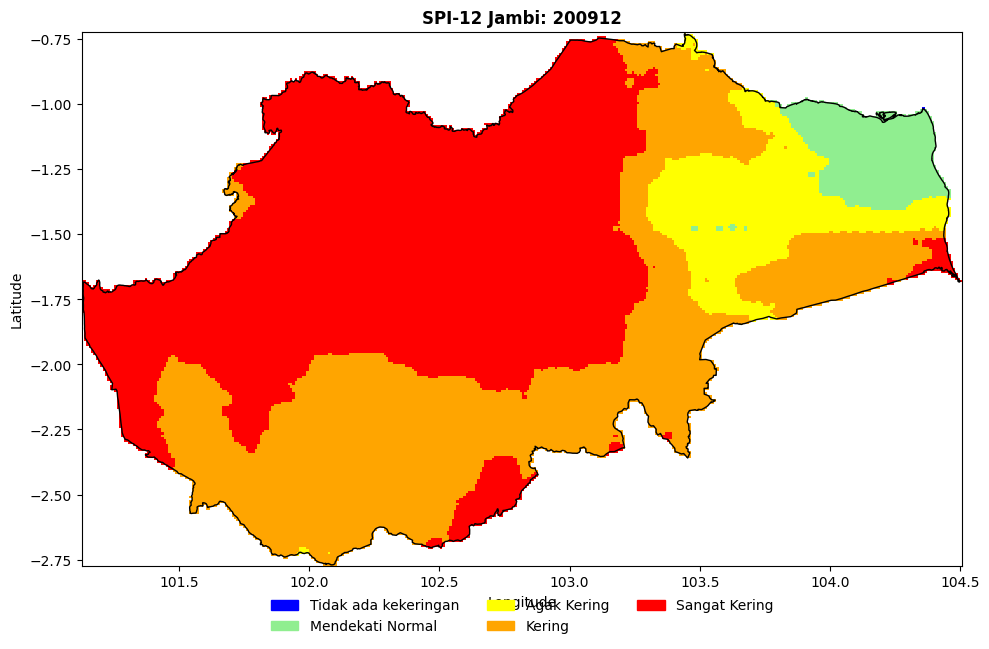

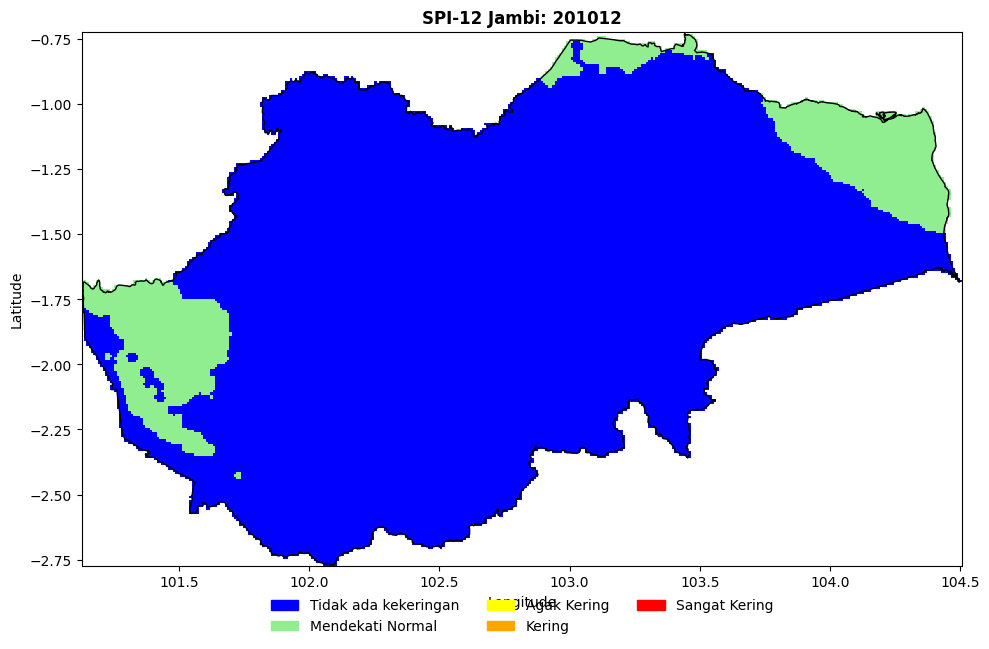

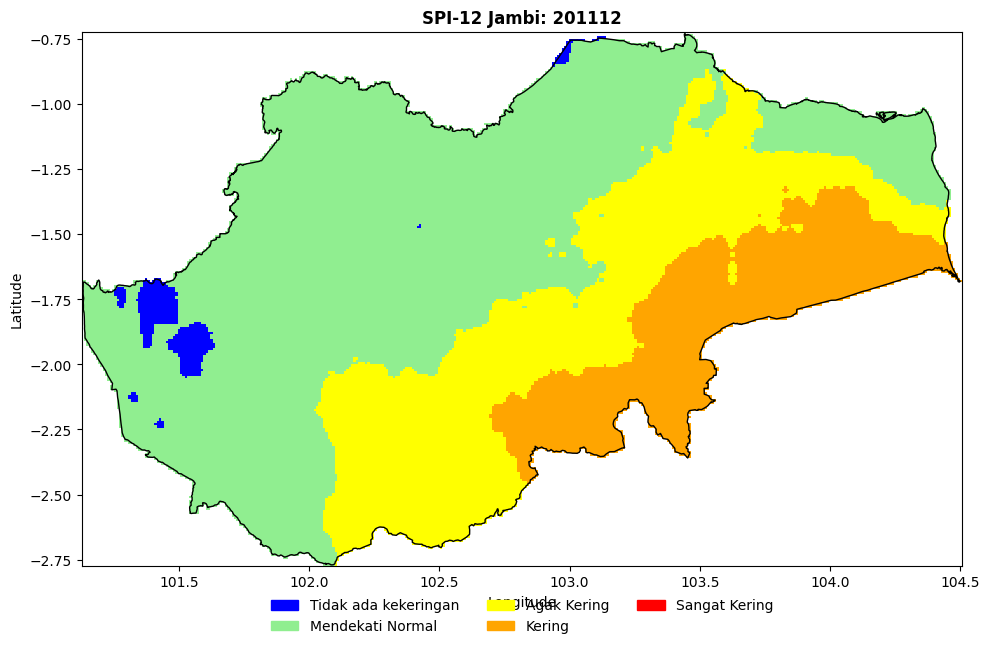

[SELESAI] Periode 2009-2011 tersimpan.

MEMPROSES SPI-12: 2012-2013
(Memuat data buffer dari tahun 2011 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2011 s.d 2013...
>> Menghitung SPI-12 (Akumulasi 12 Bulan)...
>> Memotong data ke periode target: 2012 s.d 2013
>> Menyimpan output dengan nama file SPI12...


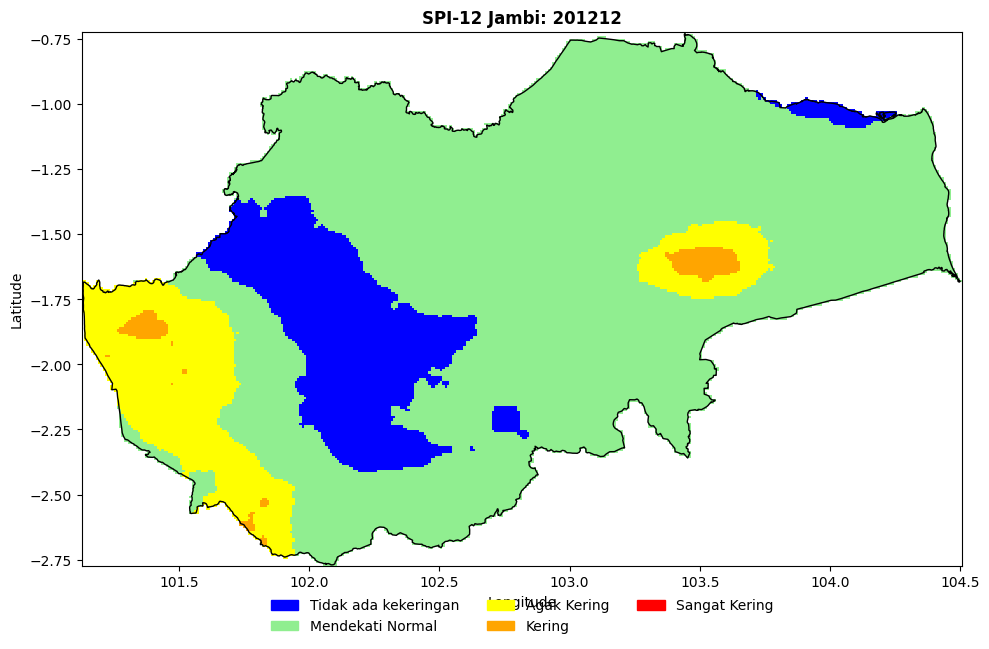

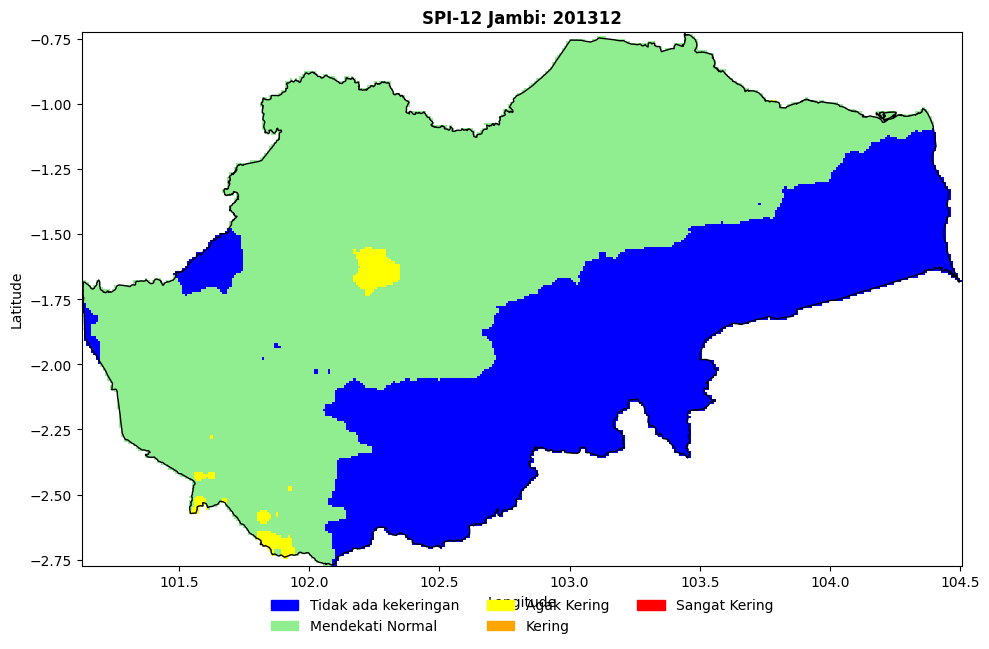

[SELESAI] Periode 2012-2013 tersimpan.

MEMPROSES SPI-12: 2014-2015
(Memuat data buffer dari tahun 2013 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2013 s.d 2015...
>> Menghitung SPI-12 (Akumulasi 12 Bulan)...
>> Memotong data ke periode target: 2014 s.d 2015
>> Menyimpan output dengan nama file SPI12...


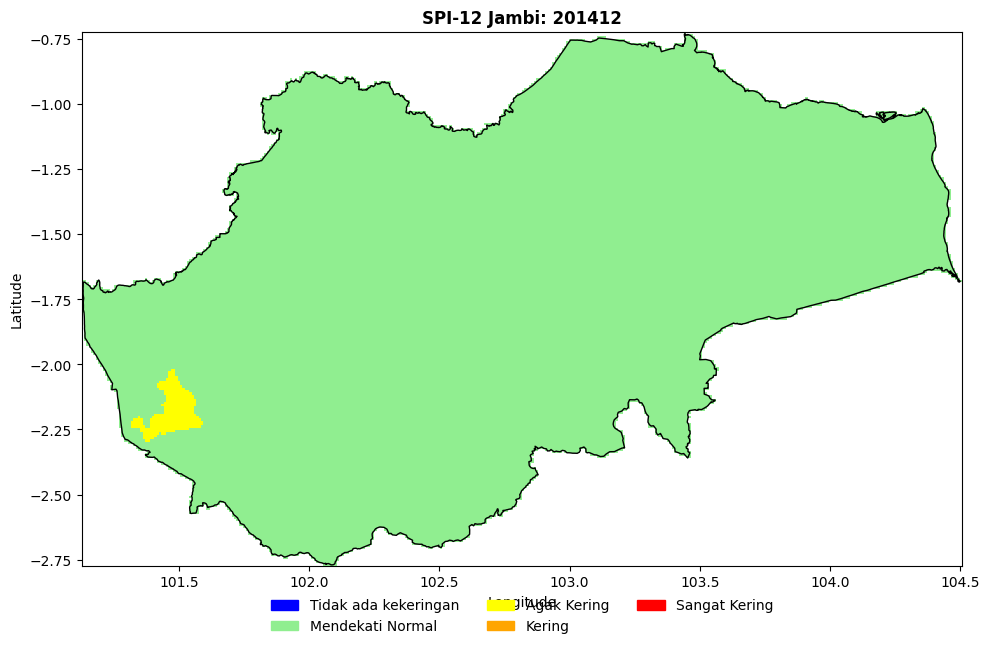

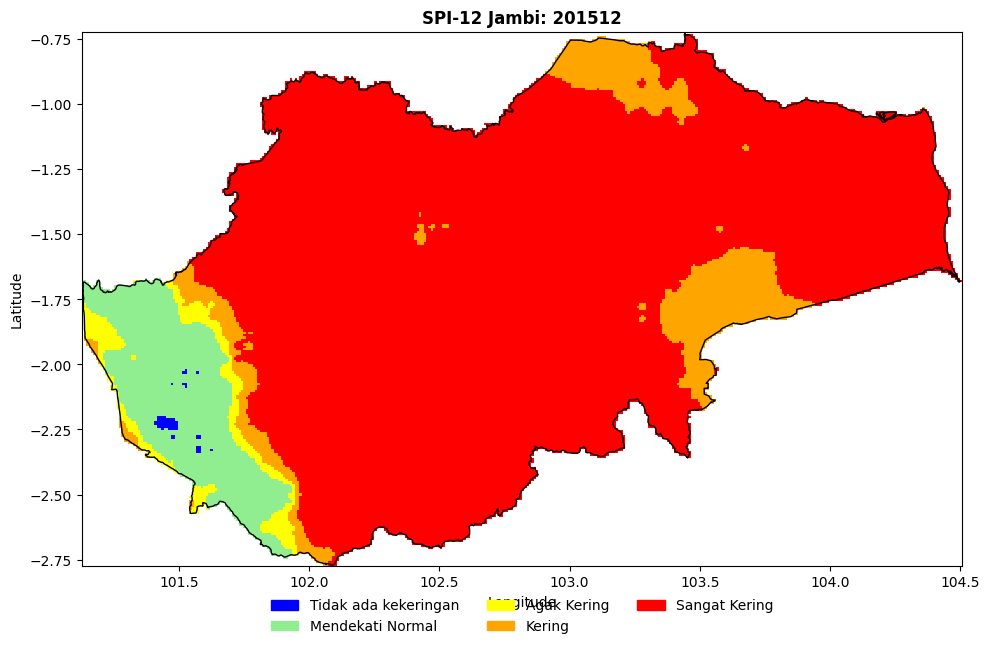

[SELESAI] Periode 2014-2015 tersimpan.

MEMPROSES SPI-12: 2016-2017
(Memuat data buffer dari tahun 2015 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2015 s.d 2017...
>> Menghitung SPI-12 (Akumulasi 12 Bulan)...
>> Memotong data ke periode target: 2016 s.d 2017
>> Menyimpan output dengan nama file SPI12...


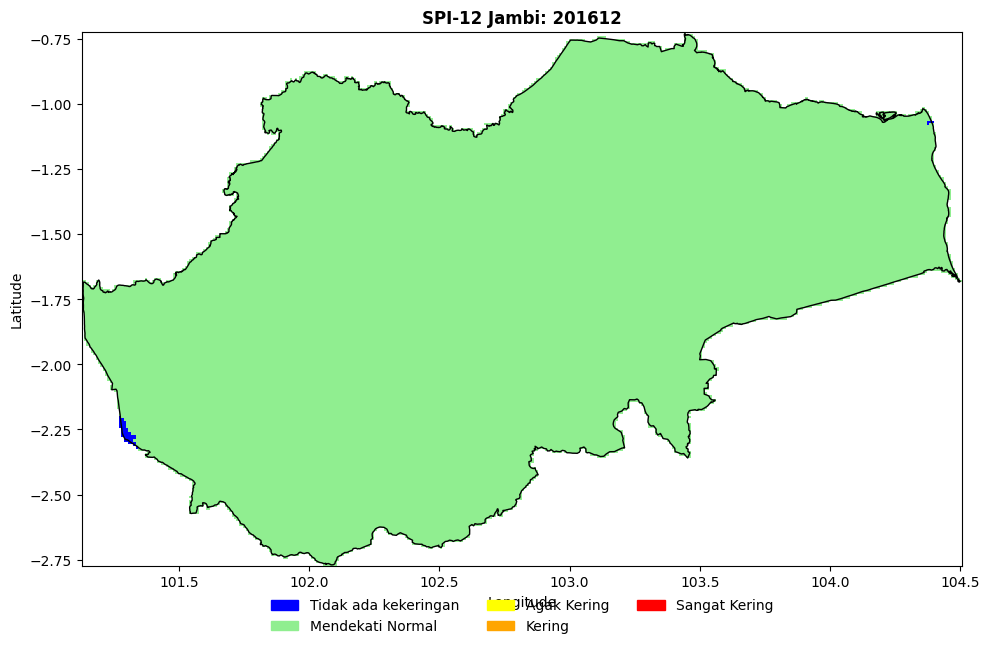

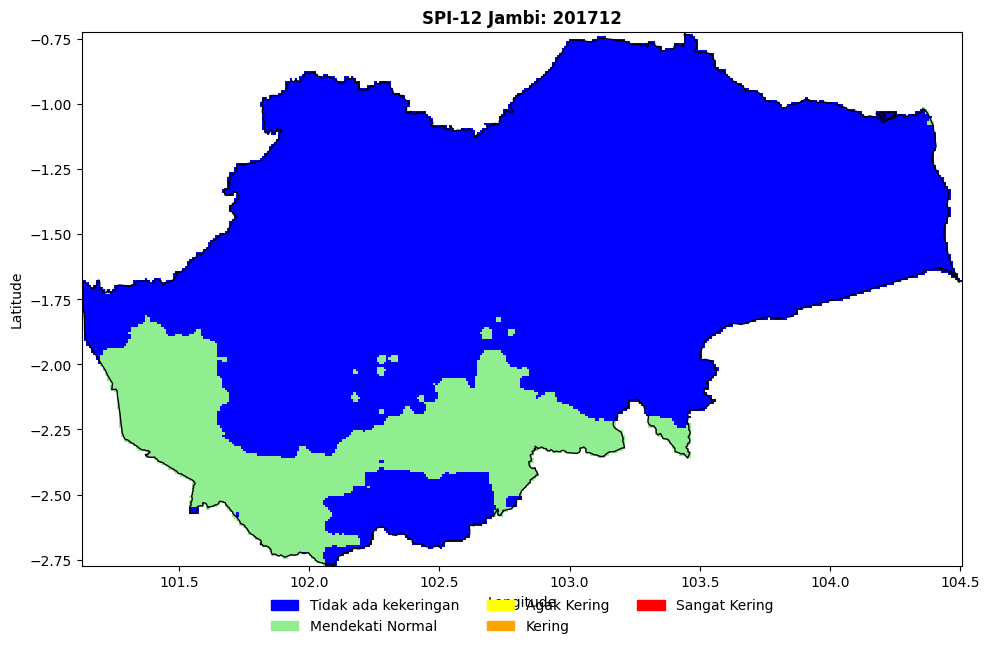

[SELESAI] Periode 2016-2017 tersimpan.

MEMPROSES SPI-12: 2018-2020
(Memuat data buffer dari tahun 2017 agar awal tahun tidak kosong)
>> Memuat data CHIRPS dari tahun 2017 s.d 2020...
>> Menghitung SPI-12 (Akumulasi 12 Bulan)...
>> Memotong data ke periode target: 2018 s.d 2020
>> Menyimpan output dengan nama file SPI12...


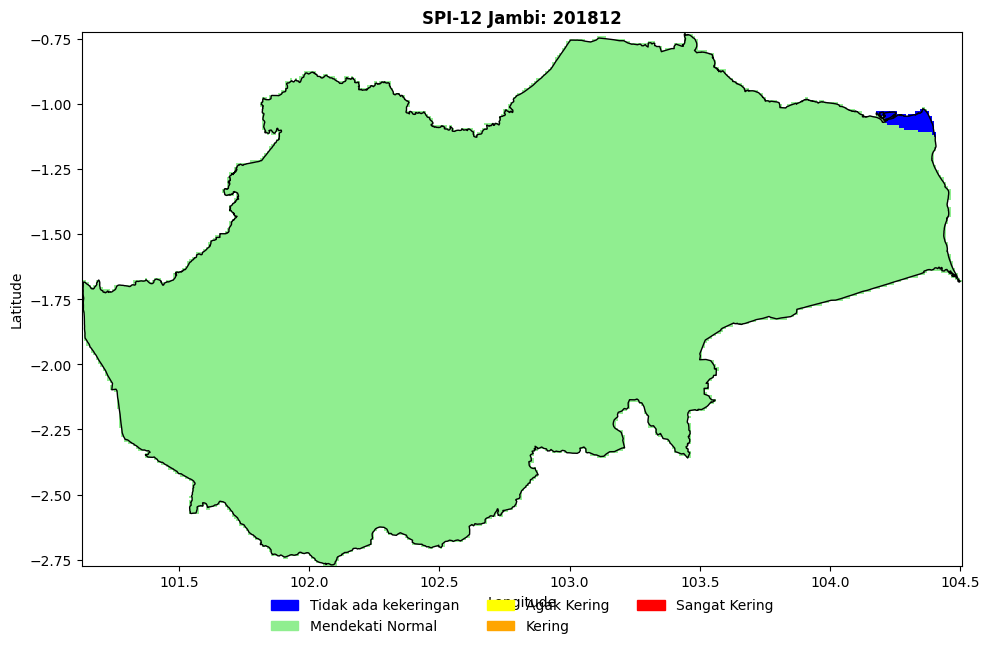

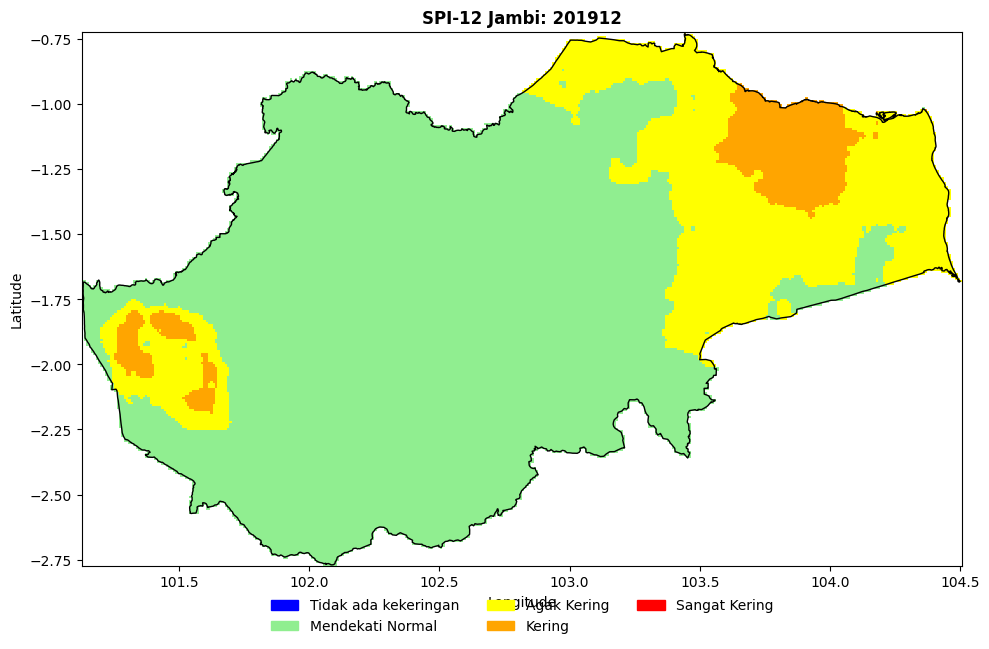

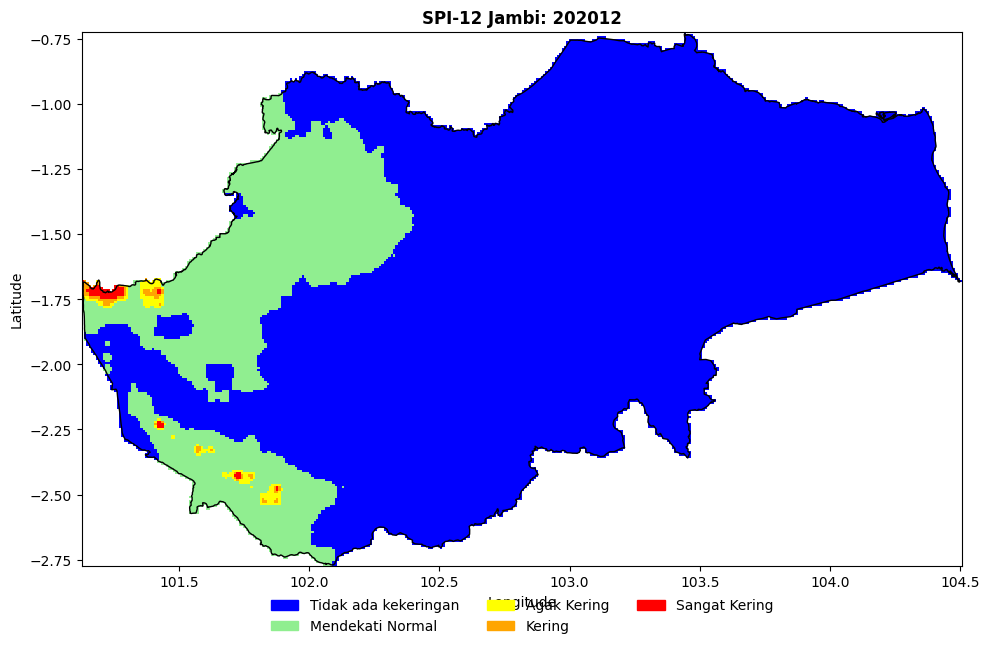

[SELESAI] Periode 2018-2020 tersimpan.


>>> SELURUH PROSES SELESAI <<<


In [ ]:
## 5. EKSEKUSI PROGRAM
# ------------------------------------------------------------------------------
if __name__ == '__main__':

    # === PERUBAHAN DI SINI ===
    # Ubah start_year menjadi 2009.
    # KONSEKUENSI:
    # 1. Bulan Jan - Nov 2009 akan KOSONG (Wajar, karena butuh data 2008).
    # 2. Bulan Desember 2009 akan TERISI.
    # 3. Bulan Jan - Des 2010 akan TERISI PENUH (Sempurna karena ada buffer 2009).
    run_processing_period(2009, 2011)

    # Periode 2: 2012 - 2013 (Buffer 2011 ada -> AMAN)
    run_processing_period(2012, 2013)

    # Periode 3: 2014 - 2015
    run_processing_period(2014, 2015)

    # Periode 4: 2016 - 2017
    run_processing_period(2016, 2017)

    # Periode 5: 2018 - 2020
    run_processing_period(2018, 2020)

    print("\n\n>>> SELURUH PROSES SELESAI <<<")